<a href="https://colab.research.google.com/github/AshOne91/PLAYDATA-COLAB/blob/main/%ED%94%84%EB%A1%AC%ED%94%84%ED%8A%B8_%EC%97%94%EC%A7%80%EB%8B%88%EC%96%B4%EB%A7%81_%EC%9D%91%EC%9A%A9(RAG(%EA%B2%80%EC%83%89_%EC%A6%9D%EA%B0%95_%EC%83%9D%EC%84%B1)).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RAG Archtecher V2(Retriver-> Re-ranker -> Generator)

RAG Architecher : Retriever - > Re-ranker-> Generator
```
Retriever : 질의와 관련된 문서를 벡터 검색으로 치기 후보군 추출(FAISS 사용)
Re-ranker : 초기 문서 후보군을 Cross-Encoder로 재정렬해 질의와의 관련성을 극대화
Generator : 선택된 문서를 기반으로 LLM(KoGPT2) 답변 생성
```
Retriever 최적화 전략
```
Embedding 모델 : 한글특화
Vector Store : FAISS 인덱싱 빠른 검색
질의재작성함수 : 정확하고 간결하게 작성 검색 정확도를 향상(ex "최신동향 추가)
```
Document 전략
```
chunking문서 : 1000자 단위로 분할,  overlab 200
metadata 활용 : 한글제목, 키워드로 필터링(ex  인공지능, 자연어 처리)
clearning : 형태소 분석, 불용어 제거, 특수문자 정규화
```
Retiever Chain 설계
```
Multi-stage Retiever : Retiever로 초기검색, Re-ranker로 정밀화
Contextual Compression : Langchain의 RetieverQA로 관련 문서만 사용
Chain 구성
```

데이터 : 한글 PDF 000개(./pdfs)
- PDF 추출
- Chunking , 메타데이터 추가
- FAISS 벡터 스토어 구축
- Retriever - Re-ranker - Gnerator 파이프라인 구축
- 테스트

In [ ]:
!pip install pdfplumber konlpy faiss-cpu rank_bm25

In [ ]:
!pip install -U langchain-community

pdf로드 ▶ 전처리 ▶ 분할 ▶임베딩/FAISS ▶ 질의변환 ▶Retiever ▶메타데이터 필터링 ▶Re-ranker ▶ context 생성 ▶ LLM연결 ▶ 답변

In [ ]:
import logging
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import HuggingFacePipeline
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.docstore.document import Document
from sentence_transformers import CrossEncoder
from transformers import pipeline, AutoTokenizer
import pdfplumber
import re
from konlpy.tag import Okt
import os
import glob
import unicodedata

# pdfminer 경고 억제
logging.getLogger("pdfminer").setLevel(logging.ERROR)

# 한글 불용어 리스트
STOPWORDS = {
    "은", "는", "이", "가", "을", "를", "에", "의", "도", "로", "와", "과", "하고", "보다",
    "에서", "까지", "으로", "라는", "한테", "에게", "처럼", "만", "뿐", "밖에", "조차", "마저",
    "따라", "대로", "만큼", "중", "등이", "등의", "것", "거", "데", "수", "등", "때", "시", "나",
    "자", "랑", "듯", "채", "줄", "다", "이다", "아니다", "되다", "하다", "있다", "없다",
    "그렇다", "같다", "그리고", "그러나", "그래서", "그런데", "또는", "혹은", "하지만", "즉", "또한", "게다가", "그러므로", "따라서",
    "그", "그거", "그것", "그곳", "여기", "저기", "거기", "이곳", "저것", "이거", "요거",
    "걔", "얘", "쟤", "누구", "아무", "어느", "어떤", "이런", "저런", "그런", "무슨",
    "아", "어", "음", "오", "어머", "아이고", "헐", "와", "우와", "에이", "흠", "흥", "응", "그래", "아니",
    "합니다", "합니다요", "입니다", "입니다요", "있습니다", "있습니다요", "합니다만",
    "그렇습니다", "그렇군요", "맞습니다", "아닙니다", "네", "예", "저", "저희", "우리"
}

# 이론 3: 한글 텍스트 전처리
def preprocess_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    # UTF-8 정규화
    text = unicodedata.normalize('NFKC', text)
    # 영어, 이메일, URL, 긴 숫자열 제거
    text = re.sub(r'[a-zA-Z]', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = re.sub(r'\d{5,}', ' ', text)  # 5자리 이상 숫자열 제거
    # 한글, 숫자, 공백만 유지
    text = re.sub(r'[^\w\s\uAC00-\uD7A30-9]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    # 최대 길이 제한
    if len(text) > 1000:
        text = text[:1000]
    try:
        okt = Okt()
        tokens = okt.morphs(text)
        tokens = [token for token in tokens if token not in STOPWORDS]
        return ' '.join(tokens)
    except Exception as e:
        print(f"Error in Okt processing: {e}")
        return text

# 이론 3: PDF 로드 함수
def load_pdf_files(directory="./pdfs/"):
    documents = []
    for pdf_path in glob.glob(os.path.join(directory, "*.pdf")):
        try:
            with pdfplumber.open(pdf_path) as pdf:
                text = ''
                for page in pdf.pages:
                    page_text = page.extract_text()
                    if page_text:
                        text += page_text
                if text.strip():
                    processed_text = preprocess_text(text)
                    if processed_text:
                        print(f"Processed {pdf_path}: {len(processed_text)} characters")
                        documents.append(Document(
                            page_content=processed_text,
                            metadata={'source': pdf_path}
                        ))
                    else:
                        print(f"Empty processed text for {pdf_path}")
                else:
                    print(f"No text extracted from {pdf_path}")
        except Exception as e:
            print(f"Error processing {pdf_path}: {e}")
    return documents

# 이론 3: PDF 로드 및 Chunking
documents = load_pdf_files("./pdfs/")
if not documents:
    raise ValueError("No valid documents loaded from ./pdfs/")

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)
chunks = text_splitter.split_documents(documents)

# 이론 3: 메타데이터 추가
for chunk in chunks:
    chunk.metadata['title'] = os.path.basename(chunk.metadata['source'])
    chunk.metadata['keywords'] = ['RAG','전처리']

# 이론 2: 한글 특화 Embedding 및 FAISS Vector Store
tokenizer = AutoTokenizer.from_pretrained("jhgan/ko-sroberta-multitask")
embeddings = HuggingFaceEmbeddings(
    model_name="jhgan/ko-sroberta-multitask",
    model_kwargs={"device": "cpu"},
    encode_kwargs={"clean_up_tokenization_spaces": True, "truncate": True}
)
try:
    vector_store = FAISS.from_documents(chunks, embeddings)
except Exception as e:
    print(f"Error creating FAISS index: {e}")
    raise

# 이론 1: Re-ranker 모델
cross_encoder = CrossEncoder("Dongjin-kr/ko-reranker")

# 이론 1, 4: Generator (한글 LLM)
llm = HuggingFacePipeline.from_model_id(
    model_id="skt/kogpt2-base-v2",
    task="text-generation",
    pipeline_kwargs={"max_new_tokens": 200, "truncation": True,"max_length":512}
)

# 이론 1, 4: Retriever 설정
retriever = vector_store.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 10}
)

# 이론 1: Re-ranker 함수
def rerank_document(query, docs):
    if not docs:
        print("No documents retrieved.")
        return []
    pairs = [[query, doc.page_content[:1000]] for doc in docs]
    try:
        scores = cross_encoder.predict(pairs)
        print(f"Re-ranker scores: {scores}")
        # 점수 임계값 적용 (0.1 이하 제외)
        filtered_pairs = [(score, doc) for score, doc in zip(scores, docs) if score > 0.1]
        if not filtered_pairs:
            print("No documents with score > 0.1.")
            return []
        reranked = [doc for _, doc in sorted(filtered_pairs, key=lambda x: x[0], reverse=True)][:3]
        print("Reranked docs (first 100 chars):")
        for i, doc in enumerate(reranked):
            print(f"Doc {i+1}: {doc.page_content[:100]}")
        return reranked
    except Exception as e:
        print(f"Error in reranking: {e}")
        return docs[:3]

# 이론 3: 메타데이터 필터링
def filter_metadata(docs, keyword=None):
    if keyword:
        filtered = [doc for doc in docs if keyword in doc.metadata.get("keywords", [])]
        print(f"Filtered {len(filtered)} documents with keyword: {keyword}")
        return filtered
    return docs

# 이론 2: 질의 변환
def rewrite_query(query):
    processed_query = preprocess_text(query)
    print(f"Rewritten query: {processed_query}")
    return processed_query

# 이론 1, 4: 최종 RAG 파이프라인
def optimized_rag_chain(query, keyword=None):
    rewritten_query = rewrite_query(query)
    try:
        initial_docs = retriever.invoke(rewritten_query)
        print(f"Retrieved {len(initial_docs)} initial documents.")
    except Exception as e:
        print(f"Error in retrieval: {e}")
        return "검색 중 오류가 발생했습니다."
    filtered_docs = filter_metadata(initial_docs, keyword)
    reranked_docs = rerank_document(rewritten_query, filtered_docs)
    if not reranked_docs:
        return "관련 문서를 찾을 수 없습니다."

    # reranked_docs 사용
    context = "\n\n".join([doc.page_content[:500] for doc in reranked_docs])  # 문서당 500자 제한
    print(f"Context length: {len(context)} characters")
    print(f"Context preview: {context[:500]}")
    prompt_template = PromptTemplate(
        input_variables=["context", "query"],
        template="다음 문서를 기반으로 질문에 답변하세요:\n\n{context}\n\n질문: {query}\n\n답변:"
    )
    qa_chain = LLMChain(llm=llm, prompt=prompt_template)
    try:
        # 입력 토큰 수 확인
        input_text = prompt_template.format(context=context, query=rewritten_query)
        input_tokens = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512)
        print(f"Input token count: {input_tokens.input_ids.shape[1]}")
        result = qa_chain.invoke({'query': rewritten_query, 'context': context})
        return result["text"]
    except Exception as e:
        print(f"Error in QA chain: {e}")
        return "답변 생성 중 오류가 발생했습니다."



Processed ./pdfs/앙상블 기반 OCR과 RAG 기술을 활용한 ESG 서류 검토 자동화 시스템 개발.pdf: 939 characters
Processed ./pdfs/RAG 시스템 성능 향상을 위한 웹문서 본문 정제 및 추출 시스템.pdf: 1045 characters


Device set to use cpu


In [ ]:
# 테스트
query = "RAG 시스템 성능향상 방법은 무엇인가요?"
answer = optimized_rag_chain(query)
print(f"질의: {query}\n답변: {answer}")

Rewritten query: 시스템 성능 향상 방법 무엇 인가요
Retrieved 3 initial documents.


Both `max_new_tokens` (=200) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Re-ranker scores: [4.9569860e-02 7.6652080e-01 2.4865457e-04]
Reranked docs (first 100 chars):
Doc 1: 제 5회 한국 인공 지능 학술 대회 5 시스템 성능 향상 위 한 웹 문서 본문 정제 및 추출 시스템 김도현 원 일용 유상현 김현정 서울 호서 전문학교 경민 대학교 건국 대학교 요 
Context length: 500 characters
Context preview: 제 5회 한국 인공 지능 학술 대회 5 시스템 성능 향상 위 한 웹 문서 본문 정제 및 추출 시스템 김도현 원 일용 유상현 김현정 서울 호서 전문학교 경민 대학교 건국 대학교 요 약 본 논문 시스템 성능 향상 시키기 위해 웹 문서 불필요한 데이터 제거 핵심 본문 정제 하 여 추출 하 시스템 제안 한 제안 된 시스템 사용자 쿼리 웹페이지 태그 구조 분석 코사인 유 사도 태그 문장 화 활용 해본 문과 쿼리 간 유사성 측정 하 여 최적 본문 식별 한다 실험 결과 다양한 웹사이트 본문 높은 정확도 추출 하여 최신 데이터 처리 성능 강화할 있 확인 하였다 서 론 결론 대형 언어 모델 최신 데이터 처리 한계 이는 1 실험 데이터 아직 학습 되지 않은 정보 대한 응답 여러가지 제한 사항 있 본 연구 에서는 시스템 성능 검증 하 기 위해 다양한 프롬 프트 다는 의미 한다 문제 해결 하기 위해 검색 증강 생 성 를생 성 이를 통해 수집 된 웹사이트 데이터 바탕 실험 방법 사용 된다 외부 지식 참조 
Input token count: 223
질의: RAG 시스템 성능향상 방법은 무엇인가요?
답변: 다음 문서를 기반으로 질문에 답변하세요:

제 5회 한국 인공 지능 학술 대회 5 시스템 성능 향상 위 한 웹 문서 본문 정제 및 추출 시스템 김도현 원 일용 유상현 김현정 서울 호서 전문학교 경민 대학교 건국 대학교 요 약 본 논문 시스템 성능 향상 시키기 위해 웹 문서 불필요한 데이터 제거 핵심 본문 정제 하 여 추출 하 시스템 제안 한 제

openai 적용

In [ ]:
!pip install langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 2.8 MB/s eta 0:00:00


In [ ]:
import logging
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import HuggingFacePipeline
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.docstore.document import Document
from sentence_transformers import CrossEncoder
from transformers import pipeline, AutoTokenizer
import pdfplumber
import re
from konlpy.tag import Okt
import os
import glob
import unicodedata
from langchain_openai import ChatOpenAI

# pdfminer 경고 억제
logging.getLogger("pdfminer").setLevel(logging.ERROR)

# 한글 불용어 리스트
STOPWORDS = {
    "은", "는", "이", "가", "을", "를", "에", "의", "도", "로", "와", "과", "하고", "보다",
    "에서", "까지", "으로", "라는", "한테", "에게", "처럼", "만", "뿐", "밖에", "조차", "마저",
    "따라", "대로", "만큼", "중", "등이", "등의", "것", "거", "데", "수", "등", "때", "시", "나",
    "자", "랑", "듯", "채", "줄", "다", "이다", "아니다", "되다", "하다", "있다", "없다",
    "그렇다", "같다", "그리고", "그러나", "그래서", "그런데", "또는", "혹은", "하지만", "즉", "또한", "게다가", "그러므로", "따라서",
    "그", "그거", "그것", "그곳", "여기", "저기", "거기", "이곳", "저것", "이거", "요거",
    "걔", "얘", "쟤", "누구", "아무", "어느", "어떤", "이런", "저런", "그런", "무슨",
    "아", "어", "음", "오", "어머", "아이고", "헐", "와", "우와", "에이", "흠", "흥", "응", "그래", "아니",
    "합니다", "합니다요", "입니다", "입니다요", "있습니다", "있습니다요", "합니다만",
    "그렇습니다", "그렇군요", "맞습니다", "아닙니다", "네", "예", "저", "저희", "우리"
}

# 이론 3: 한글 텍스트 전처리
def preprocess_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    # UTF-8 정규화
    text = unicodedata.normalize('NFKC', text)
    # 영어, 이메일, URL, 긴 숫자열 제거
    text = re.sub(r'[a-zA-Z]', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = re.sub(r'\d{5,}', ' ', text)  # 5자리 이상 숫자열 제거
    # 한글, 숫자, 공백만 유지
    text = re.sub(r'[^\w\s\uAC00-\uD7A30-9]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    # 최대 길이 제한
    if len(text) > 1000:
        text = text[:1000]
    try:
        okt = Okt()
        tokens = okt.morphs(text)
        tokens = [token for token in tokens if token not in STOPWORDS]
        return ' '.join(tokens)
    except Exception as e:
        print(f"Error in Okt processing: {e}")
        return text

# 이론 3: PDF 로드 함수
def load_pdf_files(directory="./pdfs/"):
    documents = []
    for pdf_path in glob.glob(os.path.join(directory, "*.pdf")):
        try:
            with pdfplumber.open(pdf_path) as pdf:
                text = ''
                for page in pdf.pages:
                    page_text = page.extract_text()
                    if page_text:
                        text += page_text
                if text.strip():
                    processed_text = preprocess_text(text)
                    if processed_text:
                        print(f"Processed {pdf_path}: {len(processed_text)} characters")
                        documents.append(Document(
                            page_content=processed_text,
                            metadata={'source': pdf_path}
                        ))
                    else:
                        print(f"Empty processed text for {pdf_path}")
                else:
                    print(f"No text extracted from {pdf_path}")
        except Exception as e:
            print(f"Error processing {pdf_path}: {e}")
    return documents

# 이론 3: PDF 로드 및 Chunking
documents = load_pdf_files("./pdfs/")
if not documents:
    raise ValueError("No valid documents loaded from ./pdfs/")

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)
chunks = text_splitter.split_documents(documents)

# 이론 3: 메타데이터 추가
for chunk in chunks:
    chunk.metadata['title'] = os.path.basename(chunk.metadata['source'])
    chunk.metadata['keywords'] = ['RAG','전처리']

# 이론 2: 한글 특화 Embedding 및 FAISS Vector Store
tokenizer = AutoTokenizer.from_pretrained("jhgan/ko-sroberta-multitask")
embeddings = HuggingFaceEmbeddings(
    model_name="jhgan/ko-sroberta-multitask",
    model_kwargs={"device": "cpu"},
    encode_kwargs={"clean_up_tokenization_spaces": True, "truncate": True}
)
try:
    vector_store = FAISS.from_documents(chunks, embeddings)
except Exception as e:
    print(f"Error creating FAISS index: {e}")
    raise

# 이론 1: Re-ranker 모델
cross_encoder = CrossEncoder("Dongjin-kr/ko-reranker")

# 이론 1, 4: Generator (한글 LLM)
open_ai_key = ''
llm = ChatOpenAI(
    model_name="gpt-3.5-turbo",
    temperature=0.0,
    api_key = open_ai_key
)

# 이론 1, 4: Retriever 설정
retriever = vector_store.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 10}
)

# 이론 1: Re-ranker 함수
def rerank_document(query, docs):
    if not docs:
        print("No documents retrieved.")
        return []
    pairs = [[query, doc.page_content[:1000]] for doc in docs]
    try:
        scores = cross_encoder.predict(pairs)
        print(f"Re-ranker scores: {scores}")
        # 점수 임계값 적용 (0.1 이하 제외)
        filtered_pairs = [(score, doc) for score, doc in zip(scores, docs) if score > 0.1]
        if not filtered_pairs:
            print("No documents with score > 0.1.")
            return []
        reranked = [doc for _, doc in sorted(filtered_pairs, key=lambda x: x[0], reverse=True)][:3]
        print("Reranked docs (first 100 chars):")
        for i, doc in enumerate(reranked):
            print(f"Doc {i+1}: {doc.page_content[:100]}")
        return reranked
    except Exception as e:
        print(f"Error in reranking: {e}")
        return docs[:3]

# 이론 3: 메타데이터 필터링
def filter_metadata(docs, keyword=None):
    if keyword:
        filtered = [doc for doc in docs if keyword in doc.metadata.get("keywords", [])]
        print(f"Filtered {len(filtered)} documents with keyword: {keyword}")
        return filtered
    return docs

# 이론 2: 질의 변환
def rewrite_query(query):
    processed_query = preprocess_text(query)
    print(f"Rewritten query: {processed_query}")
    return processed_query

# 이론 1, 4: 최종 RAG 파이프라인
def optimized_rag_chain(query, keyword=None):
    rewritten_query = rewrite_query(query)
    try:
        initial_docs = retriever.invoke(rewritten_query)
        print(f"Retrieved {len(initial_docs)} initial documents.")
    except Exception as e:
        print(f"Error in retrieval: {e}")
        return "검색 중 오류가 발생했습니다."
    filtered_docs = filter_metadata(initial_docs, keyword)
    reranked_docs = rerank_document(rewritten_query, filtered_docs)
    if not reranked_docs:
        return "관련 문서를 찾을 수 없습니다."

    # reranked_docs 사용
    context = "\n\n".join([doc.page_content[:500] for doc in reranked_docs])  # 문서당 500자 제한
    print(f"Context length: {len(context)} characters")
    print(f"Context preview: {context[:500]}")
    prompt_template = PromptTemplate(
        input_variables=["context", "query"],
        template="다음 문서를 기반으로 질문에 답변하세요:\n\n{context}\n\n질문: {query}\n\n답변:"
    )
    qa_chain = LLMChain(llm=llm, prompt=prompt_template)
    try:
        # 입력 토큰 수 확인
        input_text = prompt_template.format(context=context, query=rewritten_query)
        input_tokens = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512)
        print(f"Input token count: {input_tokens.input_ids.shape[1]}")
        result = qa_chain.invoke({'query': rewritten_query, 'context': context})
        return result["text"]
    except Exception as e:
        print(f"Error in QA chain: {e}")
        return "답변 생성 중 오류가 발생했습니다."



Processed ./pdfs/앙상블 기반 OCR과 RAG 기술을 활용한 ESG 서류 검토 자동화 시스템 개발.pdf: 939 characters
Processed ./pdfs/RAG 시스템 성능 향상을 위한 웹문서 본문 정제 및 추출 시스템.pdf: 1045 characters


In [ ]:
query = "RAG 시스템 성능향상 방법은 무엇인가요?"
answer = optimized_rag_chain(query, keyword="RAG")
print(f"질의: {query}\n답변: {answer}")

Rewritten query: 시스템 성능 향상 방법 무엇 인가요
Retrieved 3 initial documents.
Filtered 3 documents with keyword: RAG
Re-ranker scores: [4.9569860e-02 7.6652080e-01 2.4865457e-04]
Reranked docs (first 100 chars):
Doc 1: 제 5회 한국 인공 지능 학술 대회 5 시스템 성능 향상 위 한 웹 문서 본문 정제 및 추출 시스템 김도현 원 일용 유상현 김현정 서울 호서 전문학교 경민 대학교 건국 대학교 요 
Context length: 500 characters
Context preview: 제 5회 한국 인공 지능 학술 대회 5 시스템 성능 향상 위 한 웹 문서 본문 정제 및 추출 시스템 김도현 원 일용 유상현 김현정 서울 호서 전문학교 경민 대학교 건국 대학교 요 약 본 논문 시스템 성능 향상 시키기 위해 웹 문서 불필요한 데이터 제거 핵심 본문 정제 하 여 추출 하 시스템 제안 한 제안 된 시스템 사용자 쿼리 웹페이지 태그 구조 분석 코사인 유 사도 태그 문장 화 활용 해본 문과 쿼리 간 유사성 측정 하 여 최적 본문 식별 한다 실험 결과 다양한 웹사이트 본문 높은 정확도 추출 하여 최신 데이터 처리 성능 강화할 있 확인 하였다 서 론 결론 대형 언어 모델 최신 데이터 처리 한계 이는 1 실험 데이터 아직 학습 되지 않은 정보 대한 응답 여러가지 제한 사항 있 본 연구 에서는 시스템 성능 검증 하 기 위해 다양한 프롬 프트 다는 의미 한다 문제 해결 하기 위해 검색 증강 생 성 를생 성 이를 통해 수집 된 웹사이트 데이터 바탕 실험 방법 사용 된다 외부 지식 참조 
Input token count: 223
질의: RAG 시스템 성능향상 방법은 무엇인가요?
답변: 시스템 성능 향상을 위해 웹 문서에서 불필요한 데이터를 제거하고 핵심 본문을 정제하여 추출하는 방법을 제안하였습니다. 사용자 쿼리와 웹페이지의 태그 구조를

RAG V1 아키텍처
```
Retriever : FAISS 벡터 스토어와 한글 임베딩( ~~~ multitask)
Generator : OpenAI : gpt-4o
Re-ranker X,  검색된 문서를  직접 LLM에 전달
디버깅 : 문서품질,검색결과,토큰 수 확인
```

In [ ]:
import logging
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import HuggingFacePipeline
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.docstore.document import Document
from sentence_transformers import CrossEncoder
from transformers import pipeline, AutoTokenizer
import pdfplumber
import re
from konlpy.tag import Okt
import os
import glob
import unicodedata
from langchain_openai import ChatOpenAI

# pdfminer 경고 억제
logging.getLogger("pdfminer").setLevel(logging.ERROR)

# 한글 불용어 리스트
STOPWORDS = {
    "은", "는", "이", "가", "을", "를", "에", "의", "도", "로", "와", "과", "하고", "보다",
    "에서", "까지", "으로", "라는", "한테", "에게", "처럼", "만", "뿐", "밖에", "조차", "마저",
    "따라", "대로", "만큼", "중", "등이", "등의", "것", "거", "데", "수", "등", "때", "시", "나",
    "자", "랑", "듯", "채", "줄", "다", "이다", "아니다", "되다", "하다", "있다", "없다",
    "그렇다", "같다", "그리고", "그러나", "그래서", "그런데", "또는", "혹은", "하지만", "즉", "또한", "게다가", "그러므로", "따라서",
    "그", "그거", "그것", "그곳", "여기", "저기", "거기", "이곳", "저것", "이거", "요거",
    "걔", "얘", "쟤", "누구", "아무", "어느", "어떤", "이런", "저런", "그런", "무슨",
    "아", "어", "음", "오", "어머", "아이고", "헐", "와", "우와", "에이", "흠", "흥", "응", "그래", "아니",
    "합니다", "합니다요", "입니다", "입니다요", "있습니다", "있습니다요", "합니다만",
    "그렇습니다", "그렇군요", "맞습니다", "아닙니다", "네", "예", "저", "저희", "우리"
}
# pdfminer 경고 제거
logging.getLogger("pdfminer").setLevel(logging.ERROR)
# 한글 텍스트 전처리
def preprocess_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    # UTF-8 정규화
    text = unicodedata.normalize('NFKC', text)
    # 영어, 이메일, URL, 긴 숫자열 제거
    text = re.sub(r'[a-zA-Z]', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = re.sub(r'\d{5,}', ' ', text)  # 5자리 이상 숫자열 제거
    # 한글, 숫자, 공백만 유지
    text = re.sub(r'[^\w\s\uAC00-\uD7A30-9]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    # 중복 텍스트 제거
    lines = text.split('\n')
    text = '\n'.join( list(dict.fromkeys(lines)) )  # list(set(lines))
    # 최대 길이 제한
    # if len(text) > 1000:
    #     text = text[:1000]
    try:
        okt = Okt()
        tokens = okt.morphs(text)
        tokens = [token for token in tokens if token not in STOPWORDS]
        return ' '.join(tokens)
    except Exception as e:
        print(f"Error in Okt processing: {e}")
        return text
# pdf 로드
# 이론 3: PDF 로드 함수
def load_pdf_files(directory="./pdfs/"):
    documents = []
    for pdf_path in glob.glob(os.path.join(directory, "*.pdf")):
        try:
            with pdfplumber.open(pdf_path) as pdf:
                text = ''
                for page in pdf.pages:
                    page_text = page.extract_text()
                    if page_text:
                        text += page_text
                if text.strip():
                    processed_text = preprocess_text(text)
                    if processed_text:
                        print(f"Processed {pdf_path}: {len(processed_text)} characters")
                        documents.append(Document(
                            page_content=processed_text,
                            metadata={'source': pdf_path}
                        ))
                    else:
                        print(f"Empty processed text for {pdf_path}")
                else:
                    print(f"No text extracted from {pdf_path}")
        except Exception as e:
            print(f"Error processing {pdf_path}: {e}")
    return documents

# 이론 3: PDF 로드 및 Chunking
documents = load_pdf_files("./pdfs/")
if not documents:
    raise ValueError("No valid documents loaded from ./pdfs/")

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)
chunks = text_splitter.split_documents(documents)

# 이론 3: 메타데이터 추가
for chunk in chunks:
    chunk.metadata['title'] = os.path.basename(chunk.metadata['source'])
    chunk.metadata['keywords'] = ['RAG','전처리']

# 이론 2: 한글 특화 Embedding 및 FAISS Vector Store
tokenizer = AutoTokenizer.from_pretrained("jhgan/ko-sroberta-multitask")
embeddings = HuggingFaceEmbeddings(
    model_name="jhgan/ko-sroberta-multitask",
    model_kwargs={"device": "cpu"},
    encode_kwargs={"clean_up_tokenization_spaces": True, "truncate": True}
)
try:
    vector_store = FAISS.from_documents(chunks, embeddings)
except Exception as e:
    print(f"Error creating FAISS index: {e}")
    raise
# Generator 생성 - openai
open_ai_key = ''
llm = ChatOpenAI(
    model_name="gpt-4o",
    temperature=0.7,
    api_key = open_ai_key
)
# 리트리버 설정
retriever = vector_store.as_retriever(
  search_type="similarity",
  search_kwargs={"k": 5}
)
# 메타데이터 필터링
def filter_metadata(docs, keyword=None):
  if keyword:
      filtered = [doc for doc in docs if keyword in doc.metadata.get("keywords", [])]
      print(f"Filtered {len(filtered)} documents with keyword: {keyword}")
      return filtered
  return docs
# 질의 변환
def rewrite_query(query):
    processed_query = preprocess_text(query)
    print(f"Rewritten query: {processed_query}")
    return processed_query
# RAG V1 파이프라인
def optimized_rag_chain(query, keyword=None):
    rewritten_query = rewrite_query(query)
    try:
        initial_docs = retriever.invoke(rewritten_query)
        print(f"Retrieved {len(initial_docs)} initial documents.")
    except Exception as e:
        print(f"Error in retrieval: {e}")
        return "검색 중 오류가 발생했습니다."
    filtered_docs = filter_metadata(initial_docs, keyword)
    if not filtered_docs:
        return "관련 문서를 찾을 수 없습니다."

    # retrieved doc 사용
    context = "\n\n".join([doc.page_content[:500] for doc in filtered_docs])  # 문서당 500자 제한
    print(f"Context length: {len(context)} characters")
    print(f"Context preview: {context[:500]}")
    prompt_template = PromptTemplate(
        input_variables=["context", "query"],
        template="다음 문서를 기반으로 질문에 답변하세요:\n\n{context}\n\n질문: {query}\n\n답변:"
    )
    qa_chain = LLMChain(llm=llm, prompt=prompt_template)
    try:
        result = qa_chain.invoke({'query': rewritten_query, 'context': context})
        return result["text"]
    except Exception as e:
        print(f"Error in QA chain: {e}")
        return "답변 생성 중 오류가 발생했습니다."


Processed ./pdfs/앙상블 기반 OCR과 RAG 기술을 활용한 ESG 서류 검토 자동화 시스템 개발.pdf: 17202 characters
Processed ./pdfs/RAG 시스템 성능 향상을 위한 웹문서 본문 정제 및 추출 시스템.pdf: 2715 characters


In [ ]:
# 테스트
query = "RAG 시스템 성능향상 방법은 무엇인가요?"
answer = optimized_rag_chain(query, keyword="RAG")
print(f"질의: {query}\n답변: {answer}")

Rewritten query: 시스템 성능 향상 방법 무엇 인가요
Retrieved 5 initial documents.
Filtered 5 documents with keyword: RAG
Context length: 2321 characters
Context preview: 본문 추출 알고리즘 개발 하여 다양한 웹 문 서 형식 에서도 일관 된 정확도 유지 할수있도록 해야한 셋 째 실시간 데이터 처리 성능 개선 하여 응답 속도 신 뢰성 높이는 중요하다 이러한 향후 과제 들 을해 결함 으로써 본 연구 최신 터 반 영 능력 더욱 강화하고 방법 실용 성 증명 하 기여 할 기대 된다 이를 통해 응답 정확도 신 뢰성 크게 향상 될 있을 참 고 문 헌 1 김휘 군 이지은 박상현 인공 지능 챗봇 위 한 검색 증강 생 성 및 벡터 데이터베이스 최적화 연구 동향 정보과학 회지 42 3 8 15 2024 2 2023 3 2311 2023 126

방법론 제 베이스 확장 성 결 합하여 답변 정확도 신뢰 도를 안 한다 개선 하는 혁신 적 인 방법 주목 받고 이러 한 시스템 에도 몇 가지 중요한 한계 점 존재 한다 첫째 앙상블 모델 기반 이미지 전 처리 가장 대표 적 인 한계 점 시스템 성능 구성 요 이미지 전 처리 에는 만능 해결 책 존재 하지 않는다 입 소 들 개별 성능 크
질의: RAG 시스템 성능향상 방법은 무엇인가요?
답변: 시스템 성능을 향상시키기 위한 방법은 여러 가지 접근 방식을 결합하여 이루어집니다. 첫째, 웹 문서에서 불필요한 데이터를 제거하고 핵심 본문을 정제하여 추출하는 시스템을 통해 사용자 쿼리와 웹페이지 태그 구조를 분석하고 코사인 유사도를 활용하여 본문과 쿼리 간의 유사성을 측정함으로써 최적의 본문을 식별합니다. 둘째, 앙상블 모델 기반의 이미지 전처리 알고리즘과 하이브리드 정보 추출 모델을 적용하여 텍스트 인식 정확도를 향상시키고, 파이프라인 레이아웃 분석 알고리즘과 재순위화 알고리즘, 앙상블 검색기를 적용하여 정보 검색과 답변 생성의 신뢰성을 최적화합

In [ ]:
# 4o 답변: 시스템 성능을 향상시키기 위한 방법은 여러 가지 접근 방식을 결합하여 이루어집니다. 첫째, 웹 문서에서 불필요한 데이터를 제거하고 핵심 본문을 정제하여 추출하는 시스템을 통해 사용자 쿼리와 웹페이지 태그 구조를 분석하고 코사인 유사도를 활용하여 본문과 쿼리 간의 유사성을 측정함으로써 최적의 본문을 식별합니다. 둘째, 앙상블 모델 기반의 이미지 전처리 알고리즘과 하이브리드 정보 추출 모델을 적용하여 텍스트 인식 정확도를 향상시키고, 파이프라인 레이아웃 분석 알고리즘과 재순위화 알고리즘, 앙상블 검색기를 적용하여 정보 검색과 답변 생성의 신뢰성을 최적화합니다. 이를 통해 실시간 데이터 처리 성능을 개선하고 응답 속도와 신뢰성을 높입니다. 이러한 방법들은 각각의 한계를 보완하고 시스템 전반의 성능을 증대시키기 위해 제안되었습니다.
# 3.5 답변: 시스템 성능 향상을 위해 웹 문서에서 불필요한 데이터를 제거하고 핵심 본문을 정제하여 추출하는 방법을 제안하였습니다. 사용자 쿼리와 웹페이지의 태그 구조를 분석하고 코사인 유사도를 활용하여 태그와 문장을 화합하여 쿼리와 본문 간의 유사성을 측정하여 최적의 본문을 식별하였습니다. 이를 통해 다양한 웹사이트의 본문을 높은 정확도로 추출하여 최신 데이터 처리 성능을 강화하였습니다.

Retrival-Augmented Generation V2(RAG++)
```
질문- 검색 - 요약/생성 세 가지 파이프라인을 통해 llm에 정보 전달
Retriever : 다중 문서 검색 벡터(Hybrid, Re-rank포함)
Knowledge Selection : 신뢰도 기반 필터링
Generator : LLM
핵심 : LLM 변경하지 않고 최신 외부 정보로 정확성을 높임

RAG : 단순히 상위k개 문서  RAG++ : 조건기반 dynamic selection
RAG++ 문서단위로 출처추적이 가능

기업문서QA / 논문요약 /의료.법률/검색기반 챗봇...
```

RAG

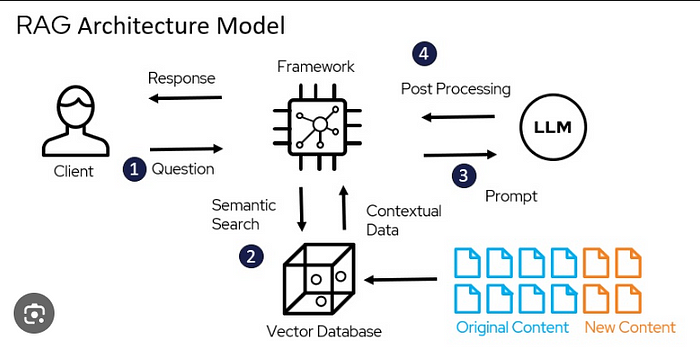

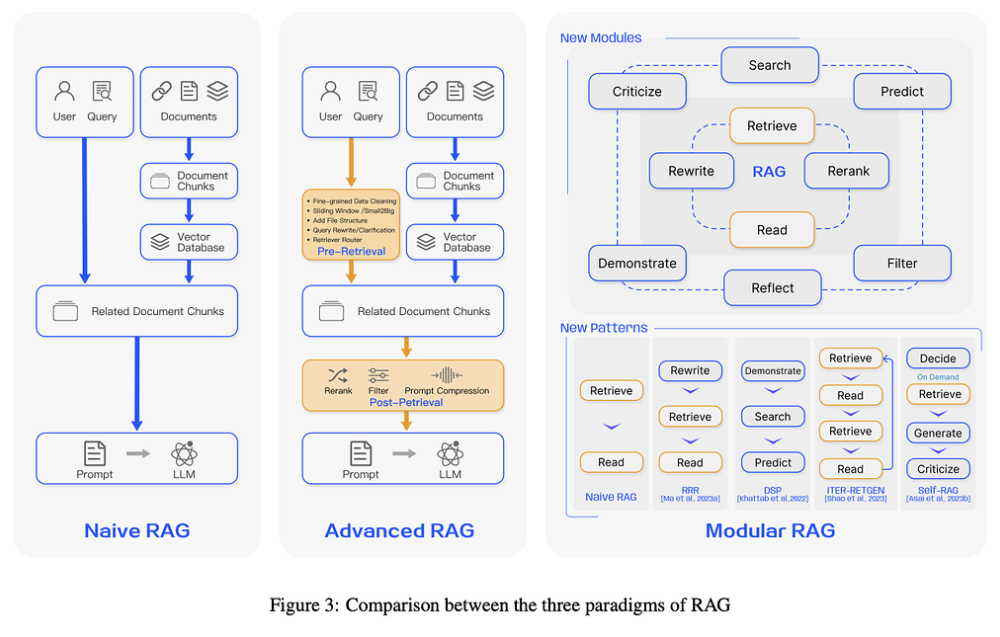

In [ ]:
# 설계
# 데이터는 "https://www.law.go.kr/precSc.do"  5개 정도 pdf로 저장
# RAG(original) + LLM(OPENIA)

# RAG(V2) + LLM(OPENIA)
#
# 불용어리스트(도메인에 따라 다름) - 법률관련 한글 불용어 리스트/사전 확보 --> chatgpt 생성
# 도메인(법률) 특화 한글전처리
# 문서로드 분할
# 메타데이터 추가
# 한글 임베딩 / FASS
# Re-Ranker 모델
# LLM
# 리트리버 설정
# 메타데이터 필터

# 법률 Pdf를 전처리 -> FAISS로 검색 -> Re-Rank로 상위 3개문서 선별 ->LLM으로 답변생

In [ ]:
# 필요라이브러리 install 및 로드
import logging
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import HuggingFacePipeline
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.docstore.document import Document
from sentence_transformers import CrossEncoder
from transformers import pipeline, AutoTokenizer
import pdfplumber
import re
from konlpy.tag import Okt
import os
import glob
import unicodedata
from langchain_openai import ChatOpenAI

# pdfminer 경고 억제
logging.getLogger("pdfminer").setLevel(logging.ERROR)
PDF_PATHS = '/content/pdf_data'
STOPWORD = [
    "및", "또는", "그리고", "그러나", "다만", "등", "같은", "경우", "때", "대한", "관련", "대해",
    "이유", "내용", "사항", "제", "조", "항", "중", "있는", "하는", "하여", "하였다", "되었다",
    "그", "이", "저", "것", "수", "있다", "없다", "한다", "된다", "되어", "되며", "또한", "때문에",
    "따라", "의하여", "의해", "위해", "받아", "바탕으로", "근거로", "결과", "판결", "사건", "사안",
    "법원", "원고", "피고", "원심", "항소심", "상고심", "대법원", "판시", "판결문", "인정", "요지",
    "재판", "청구", "기각", "인용", "심리", "적용", "해당", "해석", "주장", "판단", "사실", "진술",
    "제출", "확인", "증거", "관련", "해당", "문제", "적법", "위법", "요건", "해당", "해당하지",
    "있으며", "하고", "하며", "하는지", "한다면", "한다는", "하기", "하기에", "하였고", "되어야",
    "되어서", "되었으며", "되는", "되고", "되었고", "되기", "되고자"
]
# 법률 전용 전처리 함수(법제처에서 제공하는 판결문을 기준)
import re
def preprocess_legal_text(text):
  start_index = text.find("주 문")
  text = text[start_index + len("주 문")+3:]
  # 1. 줄 바꿈과 공백 통합 (줄 바꿈 후 띄어쓰기 많은 경우 제거)
  text = re.sub(r'\n\s*', '\n', text)

  # 2. 메타 정보 제거: 법원명, 사건번호, 당사자명, 판결일 등
  text = re.sub(r'^\s*서\s*울\s*.*?법\s*원.*?\n', '', text, flags=re.MULTILINE)  # 법원명
  text = re.sub(r'^사\s*건\s*\d{4}.*?\n', '', text, flags=re.MULTILINE)          # 사건번호
  text = re.sub(r'^(원\s*고|피\s*고)\s*.*?\n', '', text, flags=re.MULTILINE)     # 원고, 피고
  text = re.sub(r'^변\s*론\s*종\s*결.*?\n', '', text, flags=re.MULTILINE)
  text = re.sub(r'^판\s*결\s*선\s*고.*?\n', '', text, flags=re.MULTILINE)
  text = re.sub(r'^판\s*결\s*\n', '', text, flags=re.MULTILINE)

  # 3. 페이지 번호나 각주 제거
  text = re.sub(r'-\s*\d+\s*-', '', text)  # ex: - 2 -

  # 4. 이상한 줄 바꿈 복원: "연\n20%" → "연 20%"
  text = re.sub(r'([가-힣0-9])\n([가-힣0-9])', r'\1 \2', text)

  # 5. 대괄호 주석 제거 (선택적)
  text = re.sub(r'\[.*?\]', '', text)

  # 6. 불필요한 문단 헤더 (주문, 청구취지 등은 유지 여부 선택 가능)
  text = re.sub(r'^(주\s*문|청\s*구\s*취\s*지|이\s*유)\s*\n?', '', text, flags=re.MULTILINE)
  text = re.sub(r'[○□▲♤△◯◇◆■●◎☆★♥♡☞→←↔◇▽▼▲△▣◈⬛⬜◀▶]{2,}', '', text)
  # 7. 양쪽 공백 및 줄바꿈 정리
  text = text.strip()
  # 8. 판사 서명부 제거 (ex: 재판장 판사 홍길동 ________)
  text = re.sub(r'^(재판장\s*)?판사\s*[가-힣]+\s*[_―\-]{3,}$', '', text, flags=re.MULTILINE)
  # 9. 단독 n/N 문자 줄 제거
  text = re.sub(r'^\s*[nN]\s*$', '', text, flags=re.MULTILINE)
  # 10. 줄바꿈 앞뒤 불필요한 공백 제거
  text = re.sub(r'\s*\n\s*', '\n', text)
  # 11. 줄바꿈을 제거
  text = re.sub(r'\n{2,}', '\n', text)
  # (1), (2) 등 괄호 숫자 제거
  text = re.sub(r'\(\d+\)', '', text)
  # ①~⑳ 원형 숫자 제거 (유니코드 U+2460 ~ U+2473)
  text = re.sub(r'[①-⑳]', '', text)
  lines = text.split('\n')
  text = '\n'.join(list(dict.fromkeys(lines)))
  try:
    okt = Okt()
    tokens = okt.morphs(text)
    tokens = [token for token in tokens if token not in STOPWORDS]
    return ' '.join(tokens)
  except Exception as e:
    print(f"Error in Okt processing: {e}")
    return text
# 3. 법률 문서 로드 함수
def load_legal_files(directory=PDF_PATHS):
    documents = []
    for pdf_path in glob.glob(os.path.join(directory, "*.pdf")):
        try:
            with pdfplumber.open(pdf_path) as pdf:
                text = ''
                for page in pdf.pages:
                    page_text = page.extract_text()
                    if page_text:
                        text += page_text
                if text.strip():
                    processed_text = preprocess_legal_text(text)
                    if processed_text:
                        print(f"Processed {pdf_path}: {len(processed_text)} characters")
                        documents.append(Document(
                            page_content=processed_text,
                            metadata={'source': pdf_path}
                        ))
                    else:
                        print(f"Empty processed text for {pdf_path}")
                else:
                    print(f"No text extracted from {pdf_path}")
        except Exception as e:
            print(f"Error processing {pdf_path}: {e}")
    return documents

# 4. 문서 로드 및 분할
documents = load_legal_files(PDF_PATHS)
if not documents:
    raise ValueError(f"No valid documents loaded from {PDF_PATHS}")

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)
chunks = text_splitter.split_documents(documents)

# 메타데이터 추가
for chunk in chunks:
    chunk.metadata['title'] = os.path.basename(chunk.metadata['source'])
    chunk.metadata['keywords'] = ['legal']

# 5. 임베딩 및 FAISS 인덱스 생성
embeddings = HuggingFaceEmbeddings(
    model_name="jhgan/ko-sroberta-multitask",
    model_kwargs={"device": "cpu"},
    encode_kwargs={"clean_up_tokenization_spaces": True, "truncate": True}
)
try:
    vector_store = FAISS.from_documents(chunks, embeddings)
except Exception as e:
    print(f"Error creating FAISS index: {e}")
    raise

# 6. 모델 초기화
cross_encoder = CrossEncoder("Dongjin-kr/ko-reranker")
llm = ChatOpenAI(
    model="gpt-4o-mini",
    api_key=os.getenv("OPENAI_API_KEY"),
    max_tokens=200,
    temperature=0.7
)
retriever = vector_store.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 10}
)

# 7. 질의 변환 함수
def rewrite_query(query):
    processed_query = preprocess_legal_text(query)
    print(f"Rewritten query: {processed_query}")
    return processed_query

# 8. Re-ranker 함수
def rerank_document(query, docs):
    if not docs:
        print("No documents retrieved.")
        return []
    pairs = [[query, doc.page_content[:1000]] for doc in docs]
    try:
        scores = cross_encoder.predict(pairs)
        print(f"Re-ranker scores: {scores}")
        filtered_pairs = [(score, doc) for score, doc in zip(scores, docs) if score > 0.1]
        if not filtered_pairs:
            print("No documents with score > 0.1.")
            return []
        reranked = [doc for _, doc in sorted(filtered_pairs, key=lambda x: x[0], reverse=True)][:3]
        print("Reranked docs (first 100 chars):")
        for i, doc in enumerate(reranked):
            print(f"Doc {i+1}: {doc.page_content[:100]}")
        return reranked
    except Exception as e:
        print(f"Error in reranking: {e}")
        return docs[:3]

# 9. 메타데이터 필터링 함수
def filter_metadata(docs, keyword=None):
    if keyword:
        filtered = [doc for doc in docs if keyword in doc.metadata.get("keywords", [])]
        print(f"Filtered {len(filtered)} documents with keyword: {keyword}")
        return filtered
    return docs

# 10. RAG V2 파이프라인
def legal_rag_v2_chain(query, keyword="legal"):
    rewritten_query = rewrite_query(query)
    try:
        initial_docs = retriever.invoke(rewritten_query)
        print(f"Retrieved {len(initial_docs)} initial documents.")
    except Exception as e:
        print(f"Error in retrieval: {e}")
        return "검색 중 오류가 발생했습니다."
    filtered_docs = filter_metadata(initial_docs, keyword)
    reranked_docs = rerank_document(rewritten_query, filtered_docs)
    if not reranked_docs:
        return "관련 문서를 찾을 수 없습니다."

    context = "\n\n".join([doc.page_content[:500] for doc in reranked_docs])
    print(f"Context length: {len(context)} characters")
    print(f"Context preview: {context[:500]}")
    prompt_template = PromptTemplate(
        input_variables=["context", "query"],
        template="다음 법률 문서를 기반으로 질문에 답변하세요. 법률 조항이나 관련 내용을 정확히 참조하며, 간결하고 명확하게 답변하세요:\n\n{context}\n\n질문: {query}\n\n답변:"
    )
    qa_chain = LLMChain(llm=llm, prompt=prompt_template)
    try:
        result = qa_chain.invoke({'query': rewritten_query, 'context': context})
        return result["text"]
    except Exception as e:
        print(f"Error in QA chain: {e}")
        return "답변 생성 중 오류가 발생했습니다."

# 11. 테스트
query = "임대차 계약 해지 조건은 무엇인가요?"
answer = legal_rag_v2_chain(query, keyword="legal")
print(f"질의: {query}\n답변: {answer}")

Processed /content/pdf_data/03가합95465 판결전문.pdf: 6488 characters
Processed /content/pdf_data/2004가합76058 판결전문.pdf: 8159 characters
Processed /content/pdf_data/2005가합73377_판결전문.pdf: 24065 characters
Processed /content/pdf_data/2005가단197078 판결전문.pdf: 7275 characters
Processed /content/pdf_data/2005가합76758 판결전문.pdf: 6156 characters


OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable